In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.060 s)


In [4]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("PromptDataExtraction/notebooks/matplotlib.mplstyle")
except:
    try:
        plt.style.use("~/matplotlib.mplstyle")
    except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [6]:
propcount = Frame()

def execute_count(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    count = results[0][0]
    return count

In [7]:
filter_names = [
  "bandgap_ner_full",
  "co2_perm_ner_full",
  "cs_ner_full",
  "ct_ner_full",
  "dc_ner_full",
  "density_ner_full",
  "eab_ner_full",
  "fs_ner_full",
  "hardness_ner_full",
  "h2_perm_ner_full",
  "iec_ner_full",
  "ionic_cond_ner_full",
  "is_ner_full",
  "lcst_ner_full",
  "loi_ner_full",
  "methanol_perm_ner_full",
  "o2_perm_ner_full",
  "ri_ner_full",
  "sd_ner_full",
  "tc_ner_full",
  "td_ner_full",
  "tm_ner_full",
  "ts_ner_full",
  "ucst_ner_full",
  "tg_ner_full",
  "wca_ner_full",
  "wu_ner_full",
  "ym_ner_full"
]

property_names = [
  'bandgap',
  'CO_{2} permeability',
  'compressive strength',
  'crystallization temperature',
  'dielectric constant',
  'density',
  'elongation at break',
  'flexural strength',
  'hardness',
  'H_{2} permeability',
  'ion exchange capacity',
  'ionic conductivity',
  'impact strength',
  'lower critical solution temperature',
  'limiting oxygen index',
  'methanol permeability',
  'O_{2} permeability',
  'refractive index',
  'swelling degree',
  'thermal conductivity',
  'thermal decomposition temperature',
  'melting temperature',
  'tensile strength',
  'upper critical solution temperature',
  'glass transition temperature',
  'water contact angle',
  'water uptake',
  'youngs modulus'
]


In [8]:
execute(
  """
SELECT fp.para_id, fp.filter_name, em.entity_name, em.material_class, em.polymer_type, ep.entity_name as property_name, ep.numeric_value, ep.unit  
FROM filtered_paragraphs fp
LEFT JOIN extracted_materials em ON fp.para_id = em.para_id 
LEFT JOIN extracted_properties ep ON em.id = ep.material_id 
WHERE fp.filter_name = 'ym_ner_full' and em.method_id = 1 and ep.method_id = 1 and exists (
	select 1
	from property_metadata pm 
	where pm.name = 'youngs modulus'
	and ep.entity_name = any(pm.other_names)
);
"""
)

,para_id,filter_name,entity_name,material_class,polymer_type,property_name,numeric_value,unit
0,12617489,ym_ner_full,poly(p -phenylene sulfide),POLYMER,homopolymer,tensile modulus,8000.0,MPa
1,12617959,ym_ner_full,PTFE,POLYMER,homopolymer,E,16000.0,MPa
2,12617982,ym_ner_full,PTFE,POLYMER,homopolymer,Young's modulus,4800.0,MPa
3,12618538,ym_ner_full,UHMWPE,POLYMER,homopolymer,tensile modulus,130000.0,MPa
4,12619669,ym_ner_full,Teflon,POLYMER,homopolymer,tensile modulus,860.0,MPa
...,...,...,...,...,...,...,...,...
28828,6096462,ym_ner_full,BN 1-15,POLYMER,copolymer,Young's modulus,57.0,MPa
28829,6096462,ym_ner_full,BN 1-15-2,POLYMER,copolymer,Young's modulus,70.0,MPa
28830,6096581,ym_ner_full,poly­(ST),POLYMER,homopolymer,Young's tensile modulus,168.8,MPa
28831,6097779,ym_ner_full,iPP1,POLYMER,homopolymer,Young modulus,200.0,MPa


In [9]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().value.sort_values(ascending=False).index[0]
    avg = df.value.mean()
    stdev = df.value.std()

    fig, ax = plt.subplots()
    df.hist('value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    ax.set(xlabel=f'{name} ({unit})', ylabel='frequency',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    ax.grid(False)
    plt.savefig(f'notebooks/hist.{name.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [10]:
# Number of properties extracted.


count = 0
_dict = {}

for ner, prop in zip(filter_names, property_names):
  result = execute("""
          SELECT count(*)
          FROM filtered_paragraphs fp
          LEFT JOIN extracted_materials em ON fp.para_id = em.para_id 
          LEFT JOIN extracted_properties ep ON em.id = ep.material_id 
          WHERE fp.filter_name = :filter_name and em.method_id = 1 and ep.method_id = 1 and exists (
            select 1
            from property_metadata pm 
            where pm.name = :prop_name
            and ep.entity_name = any(pm.other_names)
          )
          """, filter_name = ner, prop_name = prop)
  
  print(f"{prop}: {result['count'].values[0]}")
  _dict[prop] = result['count'].values[0]
  propcount.add(property=prop, count=result['count'].values[0])
  count +=result


bandgap: 0
CO_{2} permeability: 4056
compressive strength: 8424
crystallization temperature: 8656
dielectric constant: 12436
density: 45785
elongation at break: 14892
flexural strength: 4233
hardness: 4000
H_{2} permeability: 404
ion exchange capacity: 10137
ionic conductivity: 25173
impact strength: 5344
lower critical solution temperature: 13927
limiting oxygen index: 10094
methanol permeability: 1465
O_{2} permeability: 1316
refractive index: 9317
swelling degree: 1405
thermal conductivity: 13702
thermal decomposition temperature: 9667
melting temperature: 38908
tensile strength: 46429
upper critical solution temperature: 696
glass transition temperature: 65853
water contact angle: 63552
water uptake: 6621
youngs modulus: 28833


In [11]:
_dict

{'bandgap': 0,
 'CO_{2} permeability': 4056,
 'compressive strength': 8424,
 'crystallization temperature': 8656,
 'dielectric constant': 12436,
 'density': 45785,
 'elongation at break': 14892,
 'flexural strength': 4233,
 'hardness': 4000,
 'H_{2} permeability': 404,
 'ion exchange capacity': 10137,
 'ionic conductivity': 25173,
 'impact strength': 5344,
 'lower critical solution temperature': 13927,
 'limiting oxygen index': 10094,
 'methanol permeability': 1465,
 'O_{2} permeability': 1316,
 'refractive index': 9317,
 'swelling degree': 1405,
 'thermal conductivity': 13702,
 'thermal decomposition temperature': 9667,
 'melting temperature': 38908,
 'tensile strength': 46429,
 'upper critical solution temperature': 696,
 'glass transition temperature': 65853,
 'water contact angle': 63552,
 'water uptake': 6621,
 'youngs modulus': 28833}

In [10]:
df = propcount.df.set_index('property')

In [11]:
df_filtered = propcount.df[propcount.df['count'] != 0]

In [32]:
df_filtered.columns

Index(['property', 'count'], dtype='object')

In [15]:
property = ["glass transition temperature", "melting temperature","thermal conductivity", "lower critical solution temperature",
                          "youngs modulus", "tensile strength", "elongation at break", "compressive strength",
                          "bandgap", "dielectric constant", "ionic conductivity",
                          "CO_{2} permeability", "O_{2} permeability", "water uptake", "swelling degree", "water contact angle"]

frequency = [_dict[prop] for prop in property]   

df_sample = pd.DataFrame({'property': property, 'frequency': frequency})  

In [16]:
df_sample

,property,frequency
0,glass transition temperature,65853
1,melting temperature,38908
2,thermal conductivity,13702
3,lower critical solution temperature,13927
4,youngs modulus,25755
5,tensile strength,42566
6,elongation at break,14892
7,compressive strength,8424
8,bandgap,28123
9,dielectric constant,12436


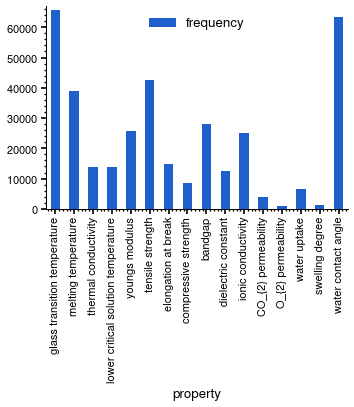

In [17]:
df_sample.plot.bar('property', 'frequency')
plt.legend()

/tmp/ipykernel_238137/2898936535.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_filtered['property'], rotation=90, ha='left')


[Text(0.0, 0, 'bandgap'),
 Text(0.2, 0, 'CO_{2} permeability'),
 Text(0.4, 0, 'compressive strength'),
 Text(0.6000000000000001, 0, 'dielectric constant'),
 Text(0.8, 0, 'density'),
 Text(1.0, 0, 'elongation at break')]

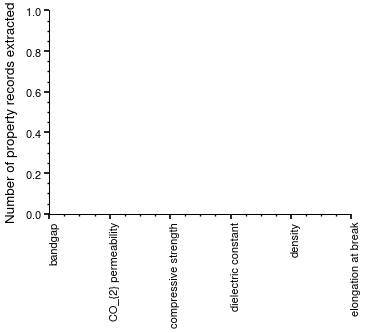

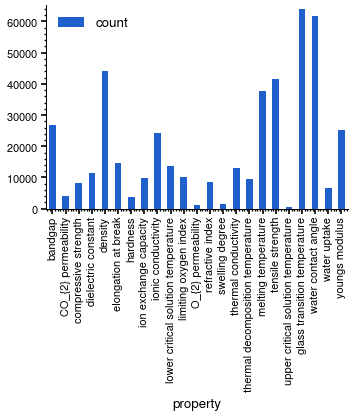

In [17]:
fig, ax = plt.subplots()
df_filtered.plot.bar('property', 'count', ax= ax)
ax.set_ylabel('Number of property records extracted')
ax.set_xticklabels(df_filtered['property'], rotation=90, ha='left')

In [77]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [7]:
def plot_histogram(df, name):
    # Most common unit
    unit = df.groupby('unit').nunique().value.sort_values(ascending=False).index[0]
    avg = df.value.mean()
    stdev = df.value.std()

    fig, ax = plt.subplots()
    df.hist('value', bins=20, label=f'Total: {df.shape[0]:,}', ax=ax)
    ax.legend()
    ax.grid(False)
    ax.set(xlabel=f'{name} ({unit})', ylabel='count',
           title=f'Extracted {name} data\nMean = {avg:0.2f}, St. dev. = {stdev:0.2f}')
    ax.set_ylabel('frequency')
    ax.set_ylim([0,27000])

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)

    plt.show()

In [18]:
df1 = execute(
  """
SELECT fp.para_id, fp.filter_name, em.entity_name, em.material_class, em.polymer_type, ep.entity_name as property_name, ep.numeric_value as value, ep.unit  
FROM filtered_paragraphs fp
LEFT JOIN extracted_materials em ON fp.para_id = em.para_id 
LEFT JOIN extracted_properties ep ON em.id = ep.material_id 
WHERE fp.filter_name = 'tg_ner_full' and em.method_id = 1 and ep.method_id = 1 and exists (
	select 1
	from property_metadata pm 
	where pm.name = 'glass transition temperature'
	and ep.entity_name = any(pm.other_names)
);
"""
)

In [19]:
df_filtered = df1[(df1['value'] < 700) & (df1['value'] > -250)]

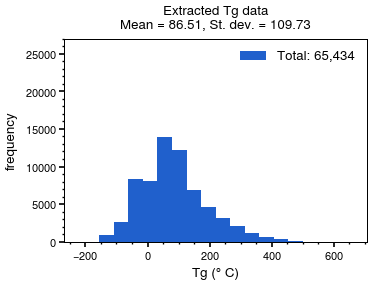

In [20]:
plot_histogram(df_filtered, 'Tg')

In [9]:
eg = execute(
  """
  SELECT fp.para_id, fp.filter_name, em.entity_name, em.material_class, em.polymer_type, ep.entity_name as property_name, ep.numeric_value as value, ep.unit  
  FROM filtered_paragraphs fp
  LEFT JOIN extracted_materials em ON fp.para_id = em.para_id 
  LEFT JOIN extracted_properties ep ON em.id = ep.material_id 
  WHERE fp.filter_name = 'bandgap_ner_full' and em.method_id = 1 and ep.method_id = 1 and exists (
    select 1
    from property_metadata pm 
    where pm.name = 'bandgap'
    and ep.entity_name = any(pm.other_names)
);
"""
)

eg_filtered = eg[(eg['value'] < 7) & (eg['value'] > 0)]

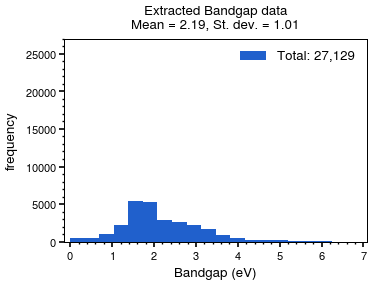

In [10]:
plot_histogram(eg_filtered, 'Bandgap')